In [1]:
import ast
import csv
import collections
import json
import os
import re
import gc
import time
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import chromadb
from chromadb.config import Settings

# Do losowania k prac
np.random.seed(42)  # Ustawienie ziarna losowości dla powtarzalności wyników

## Distribution generator

In [2]:
class VirtualAggregator:
    """
    Generates a distribution of selected papers based on specified parameters.

    Parameters:
    -----------
    k : int
        Number of citations to sample.
    N : int
        Page size for pagination.
    p : list
        List of weights for criteria: [semantic similarity, publication year, number of citations, publication venue].
    Q : str
        Query used for selecting papers.
    results_df : pandas.DataFrame
        DataFrame containing query results with columns: 'id', 'title', 'similarity', 'year', 'n_citation', 'gov_score'.

    Returns:
    --------
    Counter
        Counter object containing identifiers of selected papers and their counts.
    """
    def __init__(self):
        self.collection = None
        self.N = None
        self.k = None
        self.pn = None
        self.chroma_collection = None
        self.init_connection()

    def set_parameters(self, N, k, pn):
        self.N = N
        self.k = k
        self.pn = pn

    def init_connection(self):
        collection_status = False
        max_retries = 5
        retries = 0

        while not collection_status and retries < max_retries:
            try:
                chroma_client = chromadb.PersistentClient(path="../data/chroma")
                #chroma_client = chromadb.HttpClient(host="localhost", port=8000, settings=Settings(allow_reset=True, anonymized_telemetry=False))
                self.chroma_collection = chroma_client.get_or_create_collection(name="articles_with_score")
                collection_status = True
            except Exception as e:
                print(e)
                retries += 1
            # finally:
            #     if chroma_client:
            #         chroma_client.close() # we cant close connection 
     
        if not collection_status:
            raise Exception("Failed to connect to the collection after 5 attempts")

    def get_similar_articles(self, query_embedding, max_similarities):
        collection_status = False
        max_retries = 5
        retries = 0

        while not collection_status and retries < max_retries:
            try:
                return self.chroma_collection.query(
                    query_embeddings=[query_embedding],  # Zanurzenie zapytania
                    n_results=max_similarities  # Liczba zwracanych wyników
                )
            except Exception as e:
                print(e)
                retries += 1
            # finally:
            #     if chroma_client:
            #         chroma_client.close() # we cant close connection 
     
        if not collection_status:
            raise Exception("Failed to connect to the collection after 5 attempts")

    def distribution_function(self, number_of_pages):
        """
        Oblicza wykładniczą funkcję rozkładu dla określonej liczby stron.
    
        Args:
            number_of_pages (int): Liczba stron do rozdzielenia.
    
        Returns:
            np.ndarray: Tablica rozkładu prawdopodobieństwa dla stron.
        """
        # Tworzenie wektora od 1 do number_of_pages (włącznie) i obliczanie wykładnika ujemnego
        pages_distribution = np.exp(-np.arange(1, number_of_pages + 1))
        
        # Normalizacja, aby suma rozkładu wynosiła 1
        pages_distribution /= pages_distribution.sum()
        
        return pages_distribution

    def distribution_generator(self, collection_dict):    
        values_to_scale = np.array([
                collection_dict['year'],
                collection_dict['n_citation'],
                collection_dict['gov_score']
            ]).T

        # Dopasowanie i przekształcenie danych
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(values_to_scale)

        collection_dict['year_normalized'] = scaled_values[:, 0].tolist()
        collection_dict['citations_normalized'] = scaled_values[:, 1].tolist()
        collection_dict['points_normalized'] = scaled_values[:, 2].tolist()

        collection_dict['score'] = [
            self.pn[0] * collection_dict['similarity'][i] +
            self.pn[1] * collection_dict['year_normalized'][i] +
            self.pn[2] * collection_dict['citations_normalized'][i] +
            self.pn[3] * collection_dict['points_normalized'][i]
            for i in range(len(collection_dict['id']))
        ]

        # Tworzenie listy słowników dla posortowania
        sorted_collection = sorted(
            [
                {
                    'id': collection_dict['id'][i],
                    'title': collection_dict['title'][i],
                    'similarity': collection_dict['similarity'][i],
                    'year': collection_dict['year'][i],
                    'n_citation': collection_dict['n_citation'][i],
                    'gov_score': collection_dict['gov_score'][i],
                    'year_normalized': collection_dict['year_normalized'][i],
                    'citations_normalized': collection_dict['citations_normalized'][i],
                    'points_normalized': collection_dict['points_normalized'][i],
                    'score': collection_dict['score'][i]
                }
                for i in range(len(collection_dict['id']))
            ],
            key=lambda x: x['score'],
            reverse=True
        )
        
        # Stronicowanie wyników
        ranked_indices = [entry['id'] for entry in sorted_collection]
        pages = [ranked_indices[i:i + self.N] for i in range(0, len(ranked_indices), self.N)]
        pages_distribution = self.distribution_function(len(pages))

        last_iter_size = len(pages)
        non_empty_pages = pages

        selected_papers = []
        for _ in range(self.k):
            if self.k > self.N and _ >= self.N:
                # Problem pustej strony - pojawia sie kiedy zdejmiemy juz wszytskei dostepne artykuły z tej strony w drodze losowania bez powtórzeń
                non_empty_pages = [page for page in pages if len(page) > 0]
                if len(non_empty_pages) != last_iter_size:
                    pages_distribution = self.distribution_function(len(non_empty_pages))
                    last_iter_size = len(non_empty_pages)

            selected_page_index = np.random.choice(len(non_empty_pages), p=pages_distribution)
            selected_page = non_empty_pages[selected_page_index]                
            selected_paper_index = np.random.choice(selected_page)
            selected_papers.append(selected_paper_index)

            # Usuwanie wylosowanych wyników
            pages[selected_page_index] = [x for x in selected_page if x != selected_paper_index]

        # Zapisanie identyfikatorów wylosowanych prac
        selected_paper_counts = collections.Counter(selected_papers)

        return selected_paper_counts

    def select_papers(self, ranking):
        selected_papers = random.sample(ranking, self.k)
        return selected_papers


In [ ]:
class Experiment:
    def __init__(self, settings):
        self.virtual_aggregator = VirtualAggregator()
        self.queries = None
        self.settings = settings
        self.similar_articles = None

    def run_experiment(self, batch=40000):
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Start")
        
        self.load_queries()
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Loaded: {len(self.queries)} queries")

        already_saved = int(self.healt_check()[0]['controll_sum'])
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Already saved: {already_saved} results")

        distribution_dict = {}

        counter = 0
        result_dict = {}

        start_index = 0 + already_saved  # Ostatni indeks w liście
        end_index = start_index + batch 
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Start from {start_index} to {end_index}")

        for query_id, query in enumerate(tqdm(self.queries[start_index:end_index], total=batch, desc="Queries", unit="query")):
            self.similar_articles = self.virtual_aggregator.get_similar_articles(query.tolist(), 250)

            for sample_id, sample in enumerate(self.settings):
                self.virtual_aggregator.set_parameters(sample['N'], sample['k'], sample['pn'])
                step_distribution = self.step()

                # Save result
                if sample_id not in result_dict:
                    # Tworzenie nowych list dla nowego sample_id
                    result_dict[sample_id] = {
                        'query_id': [start_index + query_id],
                        'distribution': [dict(step_distribution)]
                    }
                else:
                    # Poszerzanie istniejących list
                    result_dict[sample_id]['query_id'].append(start_index + query_id)
                    result_dict[sample_id]['distribution'].append(dict(step_distribution))
                    
                if str(sample) in distribution_dict:                  
                    distribution_dict[str(sample)].update(step_distribution)
                else:
                    distribution_dict[str(sample)] = step_distribution

            counter += 1

            if counter % 500 == 0:
                self.save_distribution(distribution_dict)
                self.save_results(result_dict)
                result_dict = {}
    
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Final distribution saving")
        self.save_distribution(distribution_dict)

        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Final result saving")
        self.save_results(result_dict)

    def step(self):
        collection_dict = {
            'id': self.similar_articles['ids'][0],
            'title': self.similar_articles['documents'][0],
            'similarity': self.similar_articles['distances'][0],
            'year': [metadata['year'] for metadata in self.similar_articles['metadatas'][0]],
            'n_citation': [metadata['n_citation'] for metadata in self.similar_articles['metadatas'][0]],
            'gov_score': [metadata['gov_score'] for metadata in self.similar_articles['metadatas'][0]]
        }

        return self.virtual_aggregator.distribution_generator(collection_dict)

    def load_queries(self):
        df_query = pd.read_pickle('..//data//interim//queries_with_embeddings.pkl')[['embedding']]
        
        # Konwersja z użyciem tqdm
        self.queries = df_query['embedding'].tolist()

        # próba zwolnienia pamięci, mimo wszytsko jupiter trzymał RAM
        df_query = None
        del df_query
        gc.collect()

    def save_results(self, result_dict):
        for settings_id, data in result_dict.items():
            directory = f'../data/results/{settings_id}'
            os.makedirs(directory, exist_ok=True)
        
            # Ścieżka do pliku CSV
            file_path = f'{directory}/results.csv'
            file_exists = os.path.isfile(file_path)
            
            # Otwieramy plik CSV na początku pętli, żeby pisać dane w jednej operacji
            with open(file_path, 'a', newline='') as csvfile:
                fieldnames = ['query_id', 'distribution']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

                if not file_exists:
                    writer.writeheader()

                # Teraz iterujemy bezpośrednio po danych
                for i in range(len(data['query_id'])):
                    query_id = data['query_id'][i]
                    distribution = data['distribution'][i]

                    writer.writerow({
                        'query_id': query_id,
                        'distribution': distribution
                    })

    def save_distribution(self, distribution_dict):
        distribution_df = pd.DataFrame(list(distribution_dict.items()), columns=['settings', 'distribution'])
        distribution_df['distribution'] = distribution_df['distribution'].apply(lambda x: dict(x))
        distribution_df.to_csv('../distributions.csv')

    def healt_check(self):
        # Ścieżka do katalogu results
        base_path = '../data/results/'

        # Inicjalizacja słownika
        results_dict = {}

        # Pętla po wszystkich możliwych wartościach X
        for x in tqdm(range(len(self.settings)), desc="Processing result files"):
            file_path = os.path.join(base_path, str(x), 'results.csv')
            try:
                with open(file_path, 'r') as file:
                    # Zainicjalizuj zmienną licznika
                    line_count = 0
                    # Iteruj po każdej linii w pliku
                    for line in file:
                        line_count += 1
                    
                    # Odjąć nagłówek
                    line_count -= 1
                    
                    # Dodanie do słownika
                    results_dict[x] = {'controll_sum': line_count}
            except FileNotFoundError:
                results_dict[x] = {'controll_sum': None}

        return results_dict

In [6]:
def generate_all_settings():
    # Rozmiar paginy
    page_sizes = [10, 100]

    # Liczba cytowań
    citation_numbers = [10, 25, 50]

    # Możliwe wartości wag A, B, C, D
    weights = [0., 0.1, 0.25, 0.33, 0.5, 0.75, 0.9, 1.0]

    # Generowanie wszystkich możliwych kombinacji wag
    all_combinations = list(itertools.product(weights, repeat=4))

    # Filtrowanie kombinacji, aby suma wag wynosiła między 0.99 a 1.0
    valid_configs = [list(c) for c in all_combinations if 0.99 <= sum(c) <= 1.0]

    # Generowanie wszystkich możliwych ustawień
    settings = []
    for page_size in page_sizes:
        for citation_number in citation_numbers:
            for config in valid_configs:
                settings.append({
                    'N': page_size,
                    'k': citation_number,
                    'pn': config
                })

    return settings

## Program

### 1. Generate settings

In [9]:
settings = generate_all_settings()
display(settings[0])

{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.0, 1.0]}

In [12]:
import pickle
file_path = '../data/settings.pkl'

# Zapis do pliku .pkl
with open(file_path, 'wb') as file:
    pickle.dump(settings, file)

In [4]:
settings = pd.read_pickle('../data/settings.pkl')
display(settings[0])
print("Liczba wygenerowanych konfiguracji: ", len(settings))

{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.0, 1.0]}

Liczba wygenerowanych konfiguracji:  306


### 2. Run main code

In [7]:
experiment = Experiment(settings)
experiment.run_experiment()

2024-08-14 22:45:57 Start
2024-08-14 22:46:01 Loaded: 850000 queries


Processing result files: 100%|███████████████████████████████████████████████████████| 306/306 [02:51<00:00,  1.79it/s]


2024-08-14 22:48:52 Already saved: 450000 results
2024-08-14 22:48:52 Start from 450000 to 490000


Queries: 100%|██████████████████████████████████████████████████████████████| 40000/40000 [5:32:49<00:00,  2.00query/s]


2024-08-15 04:21:42 Final distribution saving
2024-08-15 04:22:04 Final result saving


###### 3. Read result

In [6]:
distribution_df = pd.read_csv('../data/results.csv')
display(distribution_df.head())

,query_id,settings,distribution
0,150,"{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.0, 1.0]}","{'358372': 1, '228408': 1, '261158': 1, '19472..."
1,150,"{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.1, 0.9]}","{'694324': 1, '453823': 1, '444086': 1, '56808..."
2,150,"{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.25, 0.75]}","{'694324': 1, '453823': 1, '444086': 1, '56808..."
3,150,"{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.5, 0.5]}","{'453823': 1, '541503': 1, '694324': 1, '19472..."
4,150,"{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.75, 0.25]}","{'70014': 1, '257451': 1, '541503': 1, '194723..."


In [3]:
path = '../data/distribution_merged.csv'
settings_pkl = '../data/settings.pkl'
settings = pd.read_pickle(settings_pkl)
display(settings[0])
print("Liczba wygenerowanych konfiguracji: ", len(settings))

{'N': 10, 'k': 10, 'pn': [0.0, 0.0, 0.0, 1.0]}

Liczba wygenerowanych konfiguracji:  306


In [ ]:
import os
import pandas as pd
import ast
import pickle
from collections import Counter
from tqdm import tqdm

def add_settings_column(base_path, settings, max_x=305):
    # Iterate over all directories from 0 to max_x
    for x in tqdm(range(0, max_x + 1), desc="Processing merged results"):
        # Define path for merged_results
        merged_results_path = os.path.join(base_path, f'distribution_merged.csv')
        
        # Check if the file exists
        if not os.path.exists(merged_results_path):
            print(f'Skipping {x} as the file is missing')
            continue

        # Load the CSV file
        df = pd.read_csv(merged_results_path)

        # Ensure the settings_id column exists
        if 'settings_id' not in df.columns:
            print(f'Skipping {x} as settings_id column is missing')
            continue

        # Map settings_id to their corresponding settings from the pkl file
        df['settings'] = df['settings_id'].map(settings)

        display(df)
        break
        # # Save the updated DataFrame back to CSV (optional: you can choose to overwrite or save as new file)
        # output_path = os.path.join(base_path, f'merged_results/{x}/merged_results_with_settings.csv')
        # df.to_csv(output_path, index=False)
        
        print(f'Updated DataFrame saved with settings for settings_id {x} at {output_path}')

# Example usage:
base_path = '../data'  # Adjust this path as necessary
add_settings_column(base_path, settings)


Processing merged results:   0%|                                                               | 0/306 [00:00<?, ?it/s]


TypeError: 'list' object is not callable

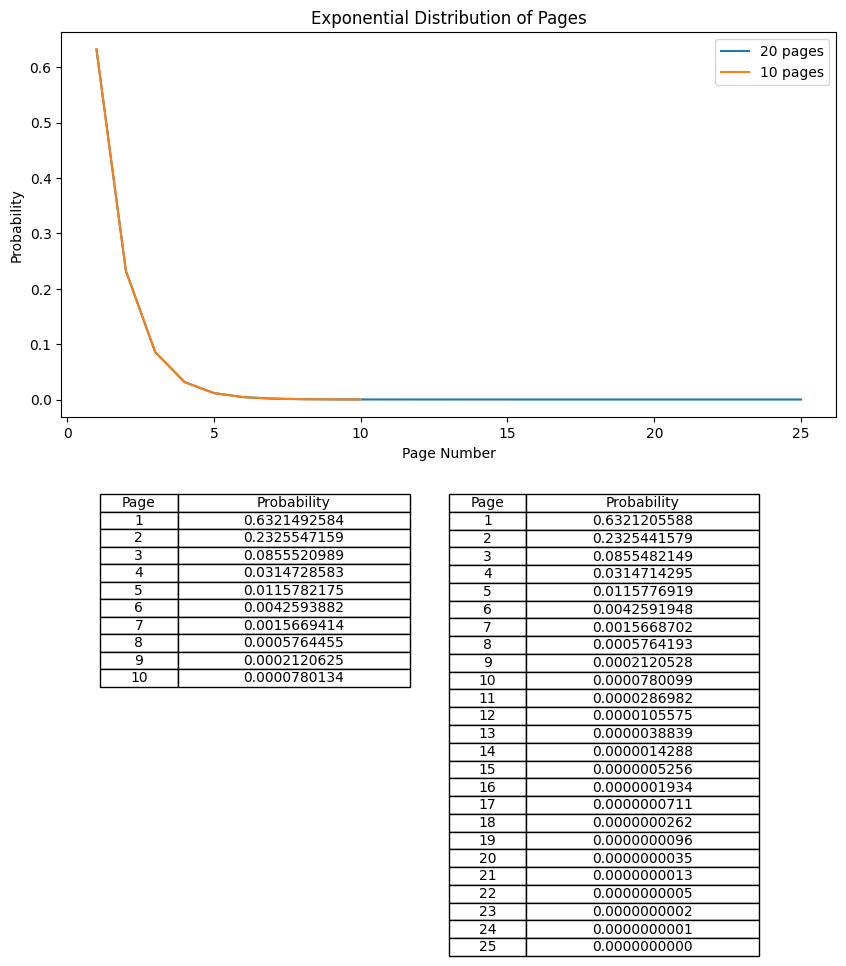

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def distribution_function(number_of_pages):
    """
    Oblicza wykładniczą funkcję rozkładu dla określonej liczby stron.

    Args:
        number_of_pages (int): Liczba stron do rozdzielenia.

    Returns:
        np.ndarray: Tablica rozkładu prawdopodobieństwa dla stron.
    """
    # Tworzenie wektora od 1 do number_of_pages (włącznie) i obliczanie wykładnika ujemnego
    pages_distribution = np.exp(-np.arange(1, number_of_pages + 1))
    
    # Normalizacja, aby suma rozkładu wynosiła 1
    pages_distribution /= pages_distribution.sum()
    
    return pages_distribution

pages_10 = np.arange(1, 10 + 1)
distribution_10 = distribution_function(10)
# # Plot the distribution
# plt.plot(pages, distribution)
# plt.xlabel('Page Number')
# plt.ylabel('Probability')
# plt.title('Exponential Distribution of Pages')
# plt.show()

# # Create a formatted list for display
# formatted_distribution = [(page, f"{dist:.10f}") for page, dist in zip(pages, distribution)]

# # Display the formatted list
# display(formatted_distribution)

# ------------------------------------------------------------------------------------------
# Załóżmy, że funkcja distribution_function jest już zdefiniowana
pages = np.arange(1, 25 + 1)
distribution = distribution_function(25)

# Utworzenie sformatowanej listy do wyświetlenia
formatted_distribution = [(page, f"{dist:.10f}") for page, dist in zip(pages, distribution)]
formatted_distribution_10 = [(page, f"{dist:.10f}") for page, dist in zip(pages_10, distribution_10)]

# Tworzenie wykresu i tabeli obok siebie
fig, ax = plt.subplots(figsize=(10, 5))

# Rysowanie wykresu na pierwszej osi
ax.plot(pages, distribution, label='20 pages')
ax.plot(pages_10, distribution_10, label='10 pages')
ax.set_xlabel('Page Number')
ax.set_ylabel('Probability')
ax.set_title('Exponential Distribution of Pages')

# Dodanie tabeli z listą po prawej stronie
table_data = [[f"{page}", f"{dist}"] for page, dist in formatted_distribution]
table_data_10 = [[f"{page}", f"{dist}"] for page, dist in formatted_distribution_10]
table = plt.table(cellText=table_data, colLabels=['Page', 'Probability'], cellLoc='center', loc='center right', bbox=[0.5, -1.4, 0.4, 1.2])
table_2 = plt.table(cellText=table_data_10, colLabels=['Page', 'Probability'], cellLoc='center', loc='center right', bbox=[0.05, -0.7, 0.4, 0.5])

# Dostosowanie szerokości kolumn tabeli
table.auto_set_column_width(col=list(range(len(table_data[0]))))  # Automatyczne dopasowanie szerokości kolumn
#table.scale(1.5, 1.5)  # Skaluje tabelę na szerokość i wysokość

# Alternatywnie ręczne ustawianie szerokości kolumn
# table.auto_set_column_width([0, 1])  # Indexy kolumn, które chcemy ustawić
# table[0, 0].set_width(0.1)  # Ustawienie szerokości dla konkretnej komórki (rząd 0, kolumna 0)
# table[0, 1].set_width(0.2)  # Ustawienie szerokości dla konkretnej komórki (rząd 0, kolumna 1)

table_2.auto_set_column_width(col=list(range(len(table_data_10[0]))))  # Automatyczne dopasowanie szerokości kolumn
# table_2.scale(1, 0.1)  # Skaluje tabelę na szerokość i wysokość

table_2.auto_set_column_width([0, 1])  # Indexy kolumn, które chcemy ustawić
table_2[0, 0].set_width(0.1)  # Ustawienie szerokości dla konkretnej komórki (rząd 0, kolumna 0)
table_2[0, 1].set_width(0.2)  # Ustawienie szerokości dla konkretnej komórki (rząd 0, kolumna 1)


# Dostosowanie układu tak, aby tabela nie nachodziła na wykres
#plt.subplots_adjust(right=0.7)
plt.legend()
# Wyświetlenie wykresu z tabelą
#plt.show()
plt.savefig('exponential_distribution_of_pages.png', bbox_inches='tight')